In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
from cosima_cookbook import explore

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.path as mpath
from matplotlib import ticker, cm
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
import glob,os
import climtas.nci
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmcrameri
import gsw



import cartopy.crs as ccrs
import cartopy.feature as cfeature

import sys
sys.path.append("/g/data/x77/ps7863/python_scripts")
import helper_functions as helper

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)


from dask.distributed import Client

figdir = '/g/data/x77/ps7863/figures/AABW_variability/'

In [2]:
climtas.nci.GadiClient()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37431,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:42611,Total threads: 1
Dashboard: /proxy/45537/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:39655,


2024-12-23 10:50:13,653 - distributed.nanny - WARNING - Restarting worker
2024-12-23 10:50:13,657 - distributed.nanny - WARNING - Restarting worker
2024-12-23 10:50:13,664 - distributed.nanny - WARNING - Restarting worker
2024-12-23 10:50:13,687 - distributed.nanny - WARNING - Restarting worker
2024-12-23 10:50:13,690 - distributed.nanny - WARNING - Restarting worker
2024-12-23 10:50:13,691 - distributed.process - WARNING - [<AsyncProcess Dask Worker process (from Nanny)>] process 484381 exit status was already read will report exitcode 255
2024-12-23 10:50:13,706 - distributed.nanny - WARNING - Restarting worker
2024-12-23 10:50:13,710 - distributed.nanny - WARNING - Restarting worker
2024-12-23 10:50:13,734 - distributed.nanny - WARNING - Restarting worker
2024-12-23 10:50:13,740 - distributed.nanny - WARNING - Restarting worker
2024-12-23 10:50:13,745 - distributed.nanny - WARNING - Restarting worker
2024-12-23 10:50:13,751 - distributed.nanny - WARNING - Restarting worker
2024-12-2

In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
expt = '01deg_jra55v140_iaf_cycle3_antarctic_tracers'

In [4]:
lon_slice = slice(80-360, 190-360)
lat_slice = slice(-82, -55)

degree =  u'\N{DEGREE SIGN}'

In [5]:
ht = cc.querying.getvar(iaf_cycle3,'ht',session, n=1) 
ht = ht.sel(yt_ocean = lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

In [6]:
shelf_mask = ht > 1000
shelf_mask = shelf_mask.astype(bool)
masked_shelf = shelf_mask.where(shelf_mask==0, np.nan)
shelf_mask = shelf_mask.where(shelf_mask==1, np.nan)
shelf_mask

<xarray.DataArray 'ht' (yt_ocean: 584, xt_ocean: 1100)> Size: 5MB
dask.array<where, shape=(584, 1100), dtype=float64, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 9kB -279.9 -279.8 -279.7 ... -170.1 -170.0
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [8]:
land_50m = cfeature.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="grey", linewidth=0.5
)

In [9]:
xt_ocean = ht.xt_ocean
yt_ocean = ht.yt_ocean

In [10]:
X, Y = np.meshgrid(xt_ocean, yt_ocean)
X = xr.DataArray(X, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])
Y = xr.DataArray(Y, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])

In [11]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """

    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(
        boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[1, ::-1], latitudes[1, ::-1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[:, 1], latitudes[:, 1]]), axis=1
    )
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

In [12]:
# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

In [13]:
first_year = 1958
last_year = 2018
start_time = f'01-01-{first_year}'
end_time = f'31-12-{last_year}'
time_slice = slice(start_time, end_time)

# Tracer concentrations

In [14]:
albw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/ALBW_tracer_bottom_500_1958-2018.nc')
rsbw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/RSBW_tracer_bottom_500_1958-2018.nc')
albw = albw['ALBW_tracer']
rsbw = rsbw['RSBW tracer']

In [15]:
albw_clim = albw.groupby('time.month').mean('time')
rsbw_clim = rsbw.groupby('time.month').mean('time')

In [32]:
fpath = '/g/data/x77/ps7863/data/Isobath_contours_circumpolar_upd/Antarctic_slope_contour_1000m.npz'

data = np.load(fpath)
lon_along_contour = data['lon_along_contour']
lat_along_contour = data['lat_along_contour']
xt_ocean = data['xt_ocean']
yt_ocean = data['yt_ocean']
xu_ocean = data['xu_ocean']
yu_ocean = data['yu_ocean']
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']


In [33]:
mask_x_transport = xr.DataArray(mask_x_transport,
                                coords = [yt_ocean, xu_ocean],
                                dims = ['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport,
                                coords = [yu_ocean, xt_ocean],
                                dims = ['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, 
                                coords = [yt_ocean, xu_ocean],
                                dims = ['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered,
                                coords = [yt_ocean, xu_ocean],
                                dims = ['y_ocean', 'x_ocean'])

In [34]:
lon_slice = slice(0,1100)
mask_x_transport = mask_x_transport.isel(x_ocean=lon_slice)
mask_y_transport = mask_y_transport.isel(x_ocean=lon_slice)
mask_x_transport_numbered = mask_x_transport_numbered.isel(x_ocean=lon_slice)
mask_y_transport_numbered = mask_y_transport_numbered.isel(x_ocean=lon_slice)

In [29]:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)


In [30]:
lat_range = slice(-82, -59)
albw_slice = albw.sel(yt_ocean=lat_range)
rsbw_slice = rsbw.sel(yt_ocean=lat_range)

In [36]:
import xgcm

In [37]:
''' Interpolate tracers onto transport grids '''

folder = '/g/data/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output005/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')
grid = grid.sel(yt_ocean=lat_range, yu_ocean=lat_range).isel(xt_ocean=lon_slice, xu_ocean=lon_slice)

ds = xr.merge([albw_slice, rsbw_slice, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=False)

In [38]:
ds = ds.rename({'RSBW tracer': 'RSBW_tracer'})

In [35]:

albw_xgrid = grid.interp(ds.ALBW_tracer, 'X')
albw_ygrid = grid.interp(ds.ALBW_tracer, 'Y')
rsbw_xgrid = grid.interp(ds.RSBW_tracer, 'X')
rsbw_ygrid = grid.interp(ds.RSBW_tracer, 'Y')

albw_xgrid = albw_xgrid.rename({'yt_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'})
albw_ygrid = albw_ygrid.rename({'yu_ocean': 'y_ocean', 'xt_ocean': 'x_ocean'})
rsbw_xgrid = rsbw_xgrid.rename({'yt_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'})
rsbw_ygrid = rsbw_ygrid.rename({'yu_ocean': 'y_ocean', 'xt_ocean': 'x_ocean'})

In [81]:
def compute_var_along_contour(var_x, var_y, var_along_contour):    
    print(time_step)
    # This is faster if we load first here:
    var_x_i = var_x[time_step,...]
    
    var_y_i = var_y[time_step,...]
    
    var_x = var_x_i.where(mask_x_transport_numbered > 0)
    var_y = var_y_i.where(mask_y_transport_numbered > 0)
    x_var_1d = var_x_i.stack(contour_index=['y_ocean', 'x_ocean'])
    y_var_1d = var_y_i.stack(contour_index=['y_ocean', 'x_ocean'])
    x_var_1d = x_var_1d.where(mask_x_numbered_1d > 0, drop=True)
    y_var_1d = y_var_1d.where(mask_y_numbered_1d > 0, drop=True)
    
    var_along_contour_i = xr.concat((x_var_1d, y_var_1d), dim = 'contour_index')
    var_along_contour_i = var_along_contour_i.sortby(contour_ordering)
    var_along_contour_i.coords['contour_index'] = contour_index_array
    var_along_contour_i = var_along_contour_i.load()
    # write into larger array:
    var_along_contour[time_step,:] = var_along_contour_i

    del var_x_i, var_y_i, x_var_1d, y_var_1d, var_along_contour_i


In [46]:
var_x_i = albw_xgrid[10,...]
var_y_i = albw_ygrid[10,...]
var_x = var_x_i.where(mask_x_transport_numbered > 0)
var_y = var_y_i.where(mask_y_transport_numbered > 0)
x_var_1d = var_x_i.stack(contour_index=['y_ocean', 'x_ocean'])
y_var_1d = var_y_i.stack(contour_index=['y_ocean', 'x_ocean'])
x_var_1d = x_var_1d.where(mask_x_numbered_1d > 0, drop=True)
y_var_1d = y_var_1d.where(mask_y_numbered_1d > 0, drop=True)

var_along_contour_i = xr.concat((x_var_1d, y_var_1d), dim = 'contour_index')
var_along_contour_i = var_along_contour_i.sortby(contour_ordering)
# var_along_contour_i.coords['contour_index'] = contour_index_array
# var_along_contour_i = var_along_contour_i.load()
# # write into larger array:
# var_along_contour[time_step,:,:] = var_along_contour_i

ValueError: cannot reindex or align along dimension 'contour_index' because the (pandas) index has duplicate values

In [87]:
mask_x_transport_numbered = mask_x_transport_numbered.isel(x_ocean=lon_slice_1)
mask_y_transport_numbered = mask_y_transport_numbered.isel(x_ocean=lon_slice_1)
mask_x_transport = mask_x_transport.isel(x_ocean=lon_slice_1)
mask_y_transport = mask_y_transport.isel(x_ocean=lon_slice_1)

mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)


In [90]:
for time_step in range(len(albw_along_contour.time)):
    compute_var_along_contour(albw_xgrid, albw_ygrid, albw_along_contour)
        

0


ValueError: cannot reindex or align along dimension 'contour_index' because the (pandas) index has duplicate values

In [49]:
yt_ocean = cc.querying.getvar(iaf_cycle3, 'yt_ocean', session, n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(iaf_cycle3, 'yu_ocean', session, n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(iaf_cycle3, 'xt_ocean', session, n=1)
xu_ocean = cc.querying.getvar(iaf_cycle3, 'xu_ocean', session, n=1)

In [98]:
isobath_depth = 1000
outfile = (
    '/g/data/g40/akm157/model_data/access-om2/Antarctic_slope_contour_' +
    str(isobath_depth) + 'm.npz')
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

In [99]:
mask_x_transport = xr.DataArray(
    mask_x_transport,
    coords=[('y_ocean', yt_ocean.data), ('x_ocean', xu_ocean.data)])
mask_y_transport = xr.DataArray(
    mask_y_transport,
    coords=[('y_ocean', yu_ocean.data), ('x_ocean', xt_ocean.data)])
mask_x_transport_numbered = xr.DataArray(
    mask_x_transport_numbered,
    coords=[('y_ocean', yt_ocean.data), ('x_ocean', xu_ocean.data)])
mask_y_transport_numbered = xr.DataArray(
    mask_y_transport_numbered,
    coords=[('y_ocean', yu_ocean.data), ('x_ocean', xt_ocean.data)])

In [87]:
(145-80)/0.1

650.0

## Slice the 1000 m contour between 125 and 145ºE

In [100]:
lon_slice_1 = slice(450, 650)

In [101]:
mask_x_transport_numbered = mask_x_transport_numbered.isel(x_ocean=lon_slice_1)
mask_y_transport_numbered = mask_y_transport_numbered.isel(x_ocean=lon_slice_1)
mask_x_transport = mask_x_transport.isel(x_ocean=lon_slice_1)
mask_y_transport = mask_y_transport.isel(x_ocean=lon_slice_1)

In [102]:
num_points = int(np.maximum(np.max(mask_y_transport_numbered),
                 np.max(mask_x_transport_numbered)))
num_points

953

In [103]:
mask_x_numbered_1d = mask_x_transport_numbered.stack(
    contour_index=['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(
    mask_x_numbered_1d > 0, drop=True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(
    contour_index=['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(
    mask_y_numbered_1d > 0, drop=True)
contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d),
                             dim='contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
contour_index_array = np.arange(1, len(contour_ordering)+1)
# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

In [104]:
var_x_i = albw_xgrid[10,...]
var_y_i = albw_ygrid[10,...]
var_x = var_x_i.where(mask_x_transport_numbered > 0)
var_y = var_y_i.where(mask_y_transport_numbered > 0)
x_var_1d = var_x_i.stack(contour_index=['y_ocean', 'x_ocean'])
y_var_1d = var_y_i.stack(contour_index=['y_ocean', 'x_ocean'])
x_var_1d = x_var_1d.where(mask_x_numbered_1d > 0, drop=True)
y_var_1d = y_var_1d.where(mask_y_numbered_1d > 0, drop=True)

var_along_contour_i = xr.concat((x_var_1d, y_var_1d), dim = 'contour_index')
var_along_contour_i = var_along_contour_i.sortby(contour_ordering)
var_along_contour_i.coords['contour_index'] = contour_index_array
var_along_contour_i = var_along_contour_i.load()
## write into larger array:
# var_along_contour[time_step,:,:] = var_along_contour_i

In [105]:
var_along_contour_i

<xarray.DataArray 'ALBW_tracer' (contour_index: 281)> Size: 1kB
array([0.06954505, 0.06583899, 0.06385576, 0.06086726, 0.05836055,
       0.06161864, 0.06609772, 0.06741805, 0.06671423, 0.07455301,
       0.07847013, 0.07032982, 0.0602289 , 0.07095124, 0.08341164,
       0.07477219, 0.07161222, 0.07973173, 0.08102274, 0.06851971,
       0.08379409, 0.08215421, 0.08424489, 0.08508208, 0.0841125 ,
       0.08434534, 0.07514501, 0.07431547, 0.07110691, 0.0813682 ,
       0.07788029, 0.07695779, 0.07403629, 0.07259034, 0.06632401,
       0.06222793, 0.06556092, 0.06050147, 0.05834243, 0.05656258,
       0.05278153, 0.0548844 , 0.05598002, 0.05454704, 0.05518461,
       0.05784669, 0.06472819, 0.06580824, 0.06254724, 0.06378741,
       0.06447032, 0.06269775, 0.06531887, 0.06540072, 0.06156911,
       0.06296954, 0.06439364, 0.06674817, 0.06738755, 0.0659544 ,
       0.06364471, 0.05279005, 0.06481266, 0.06591132, 0.06153721,
       0.06417181, 0.05775141, 0.06672537, 0.06661776, 0.07095638,
       0.07078178, 0.07027441, 0.07125782, 0.07348633, 0.07331307,
       0.07675041, 0.07651807, 0.07884746, 0.07981504, 0.08491178,
       0.084954  , 0.08982964, 0.09729698, 0.0926694 , 0.09675504,
       0.092354  , 0.08967657, 0.09412244, 0.10301323, 0.11678435,
       0.13950077, 0.14869888, 0.15738122, 0.16593306, 0.15497135,
       0.15634933, 0.16148886, 0.18070233, 0.19973674, 0.21635786,
...
       0.21526042, 0.20808443, 0.21763927, 0.30631894, 0.24706388,
       0.28957695, 0.26833916, 0.20483747, 0.1893069 , 0.1664986 ,
       0.17150614, 0.16289178, 0.16763979, 0.17957315, 0.18394431,
       0.23263362, 0.1617372 , 0.21808633, 0.21539   , 0.21020672,
       0.21027511, 0.2036408 , 0.22513607, 0.21023244, 0.25490025,
       0.2296299 , 0.23244587, 0.21833104, 0.23274946, 0.23608766,
       0.27593833, 0.24028084, 0.28272003, 0.33909476, 0.29101503,
       0.28907096, 0.27301177, 0.24276148, 0.21495196, 0.21938524,
       0.2620136 , 0.22409256, 0.28493676, 0.3173707 , 0.38254774,
       0.35171175, 0.34280604, 0.27639776, 0.28691006, 0.2849936 ,
       0.28050554, 0.2697053 , 0.24610984, 0.30113524, 0.28129792,
       0.27170825, 0.26239067, 0.23657006, 0.29095566, 0.2748648 ,
       0.24530798, 0.23903912, 0.24190682, 0.32300508, 0.27267972,
       0.34242186, 0.3774308 , 0.4132545 , 0.46116203, 0.24555905,
       0.20504567, 0.23558207, 0.22576164, 0.20248306, 0.19902402,
       0.1892671 , 0.16306809, 0.1379588 , 0.13801494, 0.13978449,
       0.16274008, 0.14368835, 0.1471605 , 0.2352377 , 0.16115808,
       0.20476684, 0.17974621, 0.16230136, 0.23650172, 0.17893344,
       0.22242965, 0.21784577, 0.21408269, 0.33834177, 0.263746  ,
       0.31170464], dtype=float32)
Coordinates:
    time           datetime64[ns] 8B 1958-11-16
  * contour_index  (contour_index) int64 2kB 1 2 3 4 5 6 ... 277 278 279 280 281

In [108]:
albw_along_contour = xr.DataArray(np.zeros((len(albw.time),len(contour_index_array))),
                              coords = [albw.time, contour_index_array],
                              dims = ['time','contour_index'],
                              name = 'albw_along_contour')
albw_along_contour

<xarray.DataArray 'albw_along_contour' (time: 721, contour_index: 281)> Size: 2MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time           (time) datetime64[ns] 6kB 1958-08-16T12:00:00 ... 2018-08-...
  * contour_index  (contour_index) int64 2kB 1 2 3 4 5 6 ... 277 278 279 280 281

In [109]:
for time_step in range(len(albw_along_contour.time)):
    compute_var_along_contour(albw_xgrid, albw_ygrid, albw_along_contour)
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

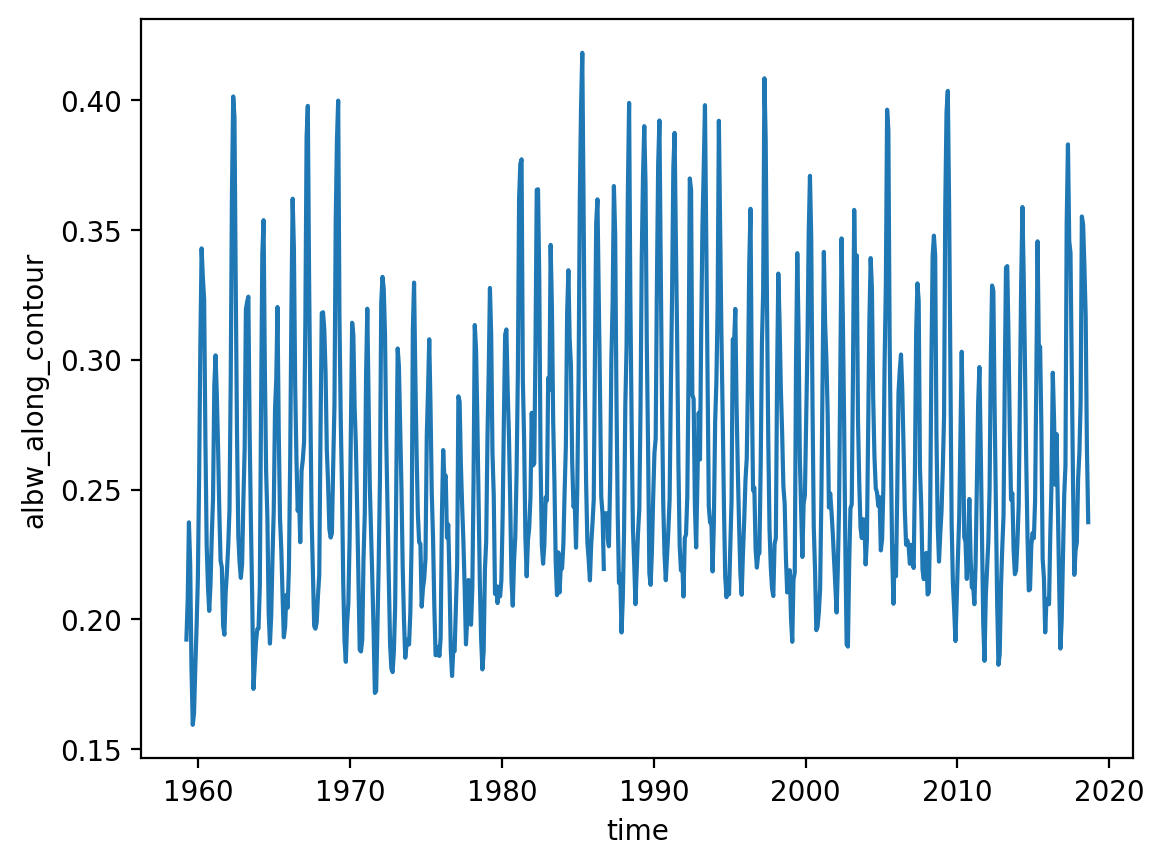

In [111]:
albw_along_contour.mean('contour_index').plot()

Text(0.5, 1.0, 'Rolling mean of ALBW tracer across the 1000 m isobath (125-145E)')

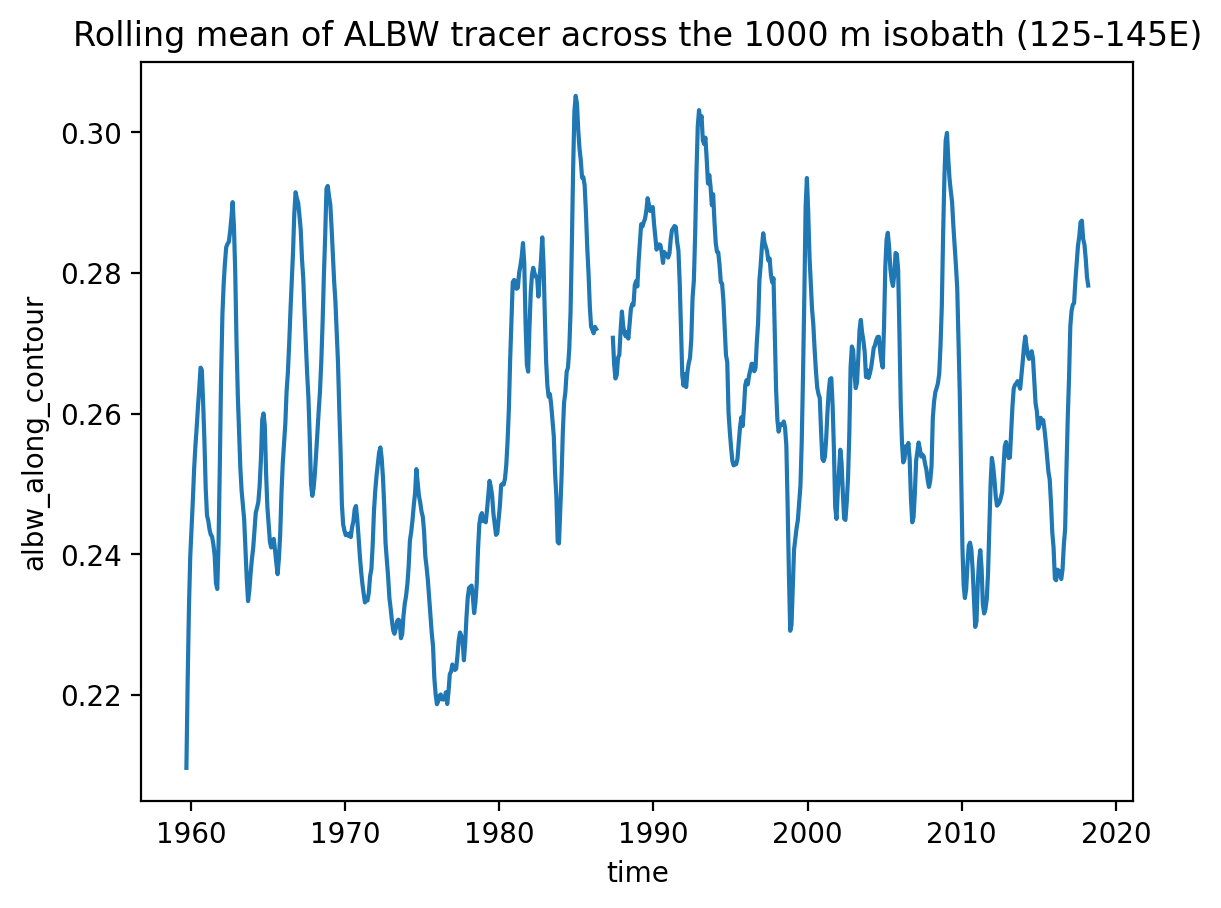

In [115]:
albw_along_contour.mean('contour_index').rolling(time=12,center=True).mean('time').plot()
plt.title('Rolling mean of ALBW tracer across the 1000 m isobath (125-145E)')

Text(0.5, 1.0, 'Seasonality of ALBW across the 1000m isobath 125-145E')

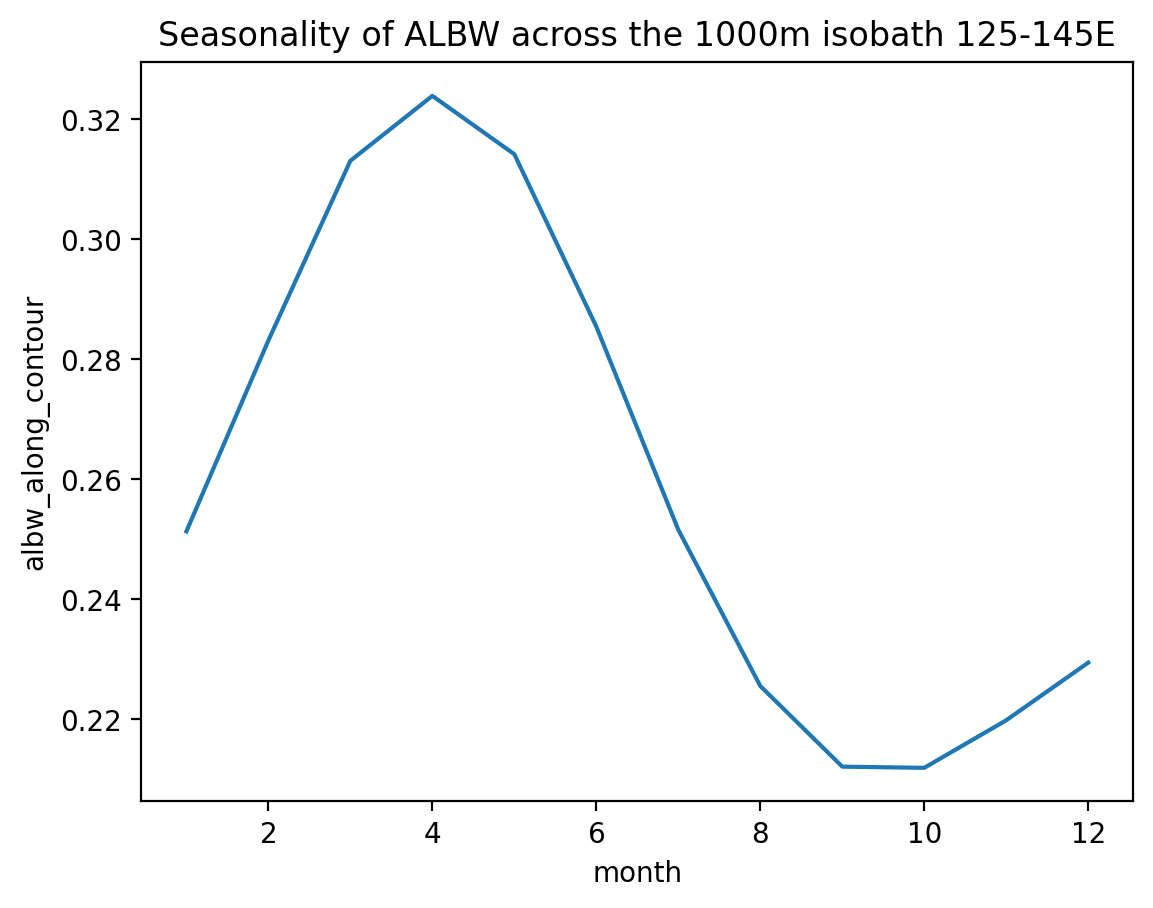

In [114]:
albw_along_contour.mean('contour_index').groupby('time.month').mean('time').plot(label='seasonality')
plt.title('Seasonality of ALBW across the 1000m isobath 125-145E')

## Tracer across the 3500 m contour between 125-138ºE

In [129]:
fpath = '/g/data/x77/ps7863/data/Isobath_contours_circumpolar_upd/Antarctic_slope_contour_3500m.npz'

data = np.load(fpath)
lon_along_contour = data['lon_along_contour']
lat_along_contour = data['lat_along_contour']
xt_ocean = data['xt_ocean']
yt_ocean = data['yt_ocean']
xu_ocean = data['xu_ocean']
yu_ocean = data['yu_ocean']
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']


In [130]:
mask_x_transport = xr.DataArray(
    mask_x_transport,
    coords=[('y_ocean', yt_ocean.data), ('x_ocean', xu_ocean.data)])
mask_y_transport = xr.DataArray(
    mask_y_transport,
    coords=[('y_ocean', yu_ocean.data), ('x_ocean', xt_ocean.data)])
mask_x_transport_numbered = xr.DataArray(
    mask_x_transport_numbered,
    coords=[('y_ocean', yt_ocean.data), ('x_ocean', xu_ocean.data)])
mask_y_transport_numbered = xr.DataArray(
    mask_y_transport_numbered,
    coords=[('y_ocean', yu_ocean.data), ('x_ocean', xt_ocean.data)])

In [120]:
(138-80)/0.1

580.0

In [131]:
lon_slice_2 = slice(450, 580)

In [132]:

mask_x_transport = mask_x_transport.isel(x_ocean=lon_slice_2)
mask_y_transport = mask_y_transport.isel(x_ocean=lon_slice_2)
mask_x_transport_numbered = mask_x_transport_numbered.isel(x_ocean=lon_slice_2)
mask_y_transport_numbered = mask_y_transport_numbered.isel(x_ocean=lon_slice_2)

In [133]:
mask_y_transport

<xarray.DataArray (y_ocean: 510, x_ocean: 130)> Size: 265kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * y_ocean  (y_ocean) float64 4kB -81.09 -81.05 -81.0 ... -59.11 -59.06 -59.01
  * x_ocean  (x_ocean) float64 1kB -234.9 -234.8 -234.7 ... -222.2 -222.1 -222.0

In [134]:
num_points = int(np.maximum(np.max(mask_y_transport_numbered),
                 np.max(mask_x_transport_numbered)))
num_points

1104

In [135]:
mask_x_numbered_1d = mask_x_transport_numbered.stack(
    contour_index=['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(
    mask_x_numbered_1d > 0, drop=True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(
    contour_index=['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(
    mask_y_numbered_1d > 0, drop=True)
contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d),
                             dim='contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
contour_index_array = np.arange(1, len(contour_ordering)+1)
# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

In [136]:
var_x_i = albw_xgrid[10,...]
var_y_i = albw_ygrid[10,...]
var_x = var_x_i.where(mask_x_transport_numbered > 0)
var_y = var_y_i.where(mask_y_transport_numbered > 0)
x_var_1d = var_x_i.stack(contour_index=['y_ocean', 'x_ocean'])
y_var_1d = var_y_i.stack(contour_index=['y_ocean', 'x_ocean'])
x_var_1d = x_var_1d.where(mask_x_numbered_1d > 0, drop=True)
y_var_1d = y_var_1d.where(mask_y_numbered_1d > 0, drop=True)

var_along_contour_i = xr.concat((x_var_1d, y_var_1d), dim = 'contour_index')
var_along_contour_i = var_along_contour_i.sortby(contour_ordering)
var_along_contour_i.coords['contour_index'] = contour_index_array
var_along_contour_i = var_along_contour_i.load()
## write into larger array:
# var_along_contour[time_step,:,:] = var_along_contour_i

In [105]:
var_along_contour_i

<xarray.DataArray 'ALBW_tracer' (contour_index: 281)> Size: 1kB
array([0.06954505, 0.06583899, 0.06385576, 0.06086726, 0.05836055,
       0.06161864, 0.06609772, 0.06741805, 0.06671423, 0.07455301,
       0.07847013, 0.07032982, 0.0602289 , 0.07095124, 0.08341164,
       0.07477219, 0.07161222, 0.07973173, 0.08102274, 0.06851971,
       0.08379409, 0.08215421, 0.08424489, 0.08508208, 0.0841125 ,
       0.08434534, 0.07514501, 0.07431547, 0.07110691, 0.0813682 ,
       0.07788029, 0.07695779, 0.07403629, 0.07259034, 0.06632401,
       0.06222793, 0.06556092, 0.06050147, 0.05834243, 0.05656258,
       0.05278153, 0.0548844 , 0.05598002, 0.05454704, 0.05518461,
       0.05784669, 0.06472819, 0.06580824, 0.06254724, 0.06378741,
       0.06447032, 0.06269775, 0.06531887, 0.06540072, 0.06156911,
       0.06296954, 0.06439364, 0.06674817, 0.06738755, 0.0659544 ,
       0.06364471, 0.05279005, 0.06481266, 0.06591132, 0.06153721,
       0.06417181, 0.05775141, 0.06672537, 0.06661776, 0.07095638,
       0.07078178, 0.07027441, 0.07125782, 0.07348633, 0.07331307,
       0.07675041, 0.07651807, 0.07884746, 0.07981504, 0.08491178,
       0.084954  , 0.08982964, 0.09729698, 0.0926694 , 0.09675504,
       0.092354  , 0.08967657, 0.09412244, 0.10301323, 0.11678435,
       0.13950077, 0.14869888, 0.15738122, 0.16593306, 0.15497135,
       0.15634933, 0.16148886, 0.18070233, 0.19973674, 0.21635786,
...
       0.21526042, 0.20808443, 0.21763927, 0.30631894, 0.24706388,
       0.28957695, 0.26833916, 0.20483747, 0.1893069 , 0.1664986 ,
       0.17150614, 0.16289178, 0.16763979, 0.17957315, 0.18394431,
       0.23263362, 0.1617372 , 0.21808633, 0.21539   , 0.21020672,
       0.21027511, 0.2036408 , 0.22513607, 0.21023244, 0.25490025,
       0.2296299 , 0.23244587, 0.21833104, 0.23274946, 0.23608766,
       0.27593833, 0.24028084, 0.28272003, 0.33909476, 0.29101503,
       0.28907096, 0.27301177, 0.24276148, 0.21495196, 0.21938524,
       0.2620136 , 0.22409256, 0.28493676, 0.3173707 , 0.38254774,
       0.35171175, 0.34280604, 0.27639776, 0.28691006, 0.2849936 ,
       0.28050554, 0.2697053 , 0.24610984, 0.30113524, 0.28129792,
       0.27170825, 0.26239067, 0.23657006, 0.29095566, 0.2748648 ,
       0.24530798, 0.23903912, 0.24190682, 0.32300508, 0.27267972,
       0.34242186, 0.3774308 , 0.4132545 , 0.46116203, 0.24555905,
       0.20504567, 0.23558207, 0.22576164, 0.20248306, 0.19902402,
       0.1892671 , 0.16306809, 0.1379588 , 0.13801494, 0.13978449,
       0.16274008, 0.14368835, 0.1471605 , 0.2352377 , 0.16115808,
       0.20476684, 0.17974621, 0.16230136, 0.23650172, 0.17893344,
       0.22242965, 0.21784577, 0.21408269, 0.33834177, 0.263746  ,
       0.31170464], dtype=float32)
Coordinates:
    time           datetime64[ns] 8B 1958-11-16
  * contour_index  (contour_index) int64 2kB 1 2 3 4 5 6 ... 277 278 279 280 281

In [137]:
albw_along_contour = xr.DataArray(np.zeros((len(albw.time),len(contour_index_array))),
                              coords = [albw.time, contour_index_array],
                              dims = ['time','contour_index'],
                              name = 'albw_along_contour')
albw_along_contour

<xarray.DataArray 'albw_along_contour' (time: 721, contour_index: 225)> Size: 1MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time           (time) datetime64[ns] 6kB 1958-08-16T12:00:00 ... 2018-08-...
  * contour_index  (contour_index) int64 2kB 1 2 3 4 5 6 ... 221 222 223 224 225

In [138]:
for time_step in range(len(albw_along_contour.time)):
    compute_var_along_contour(albw_xgrid, albw_ygrid, albw_along_contour)
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 1.0, 'Rolling mean of ALBW tracer across the 3500 m isobath (125-138E)')

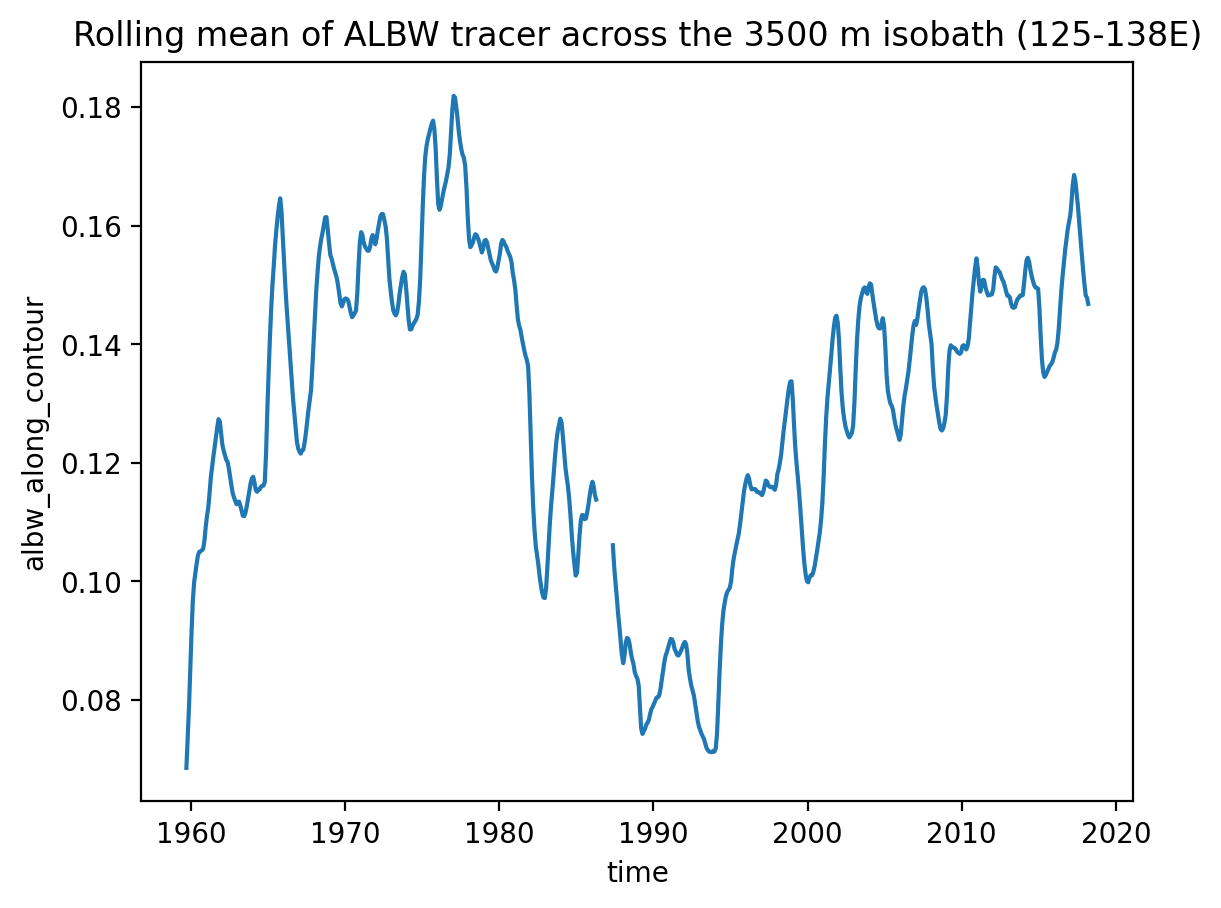

In [139]:
albw_along_contour.mean('contour_index').rolling(time=12,center=True).mean('time').plot()
plt.title('Rolling mean of ALBW tracer across the 3500 m isobath (125-138E)')

Text(0.5, 1.0, 'Seasonality of ALBW across the 3500m isobath 125-138E')

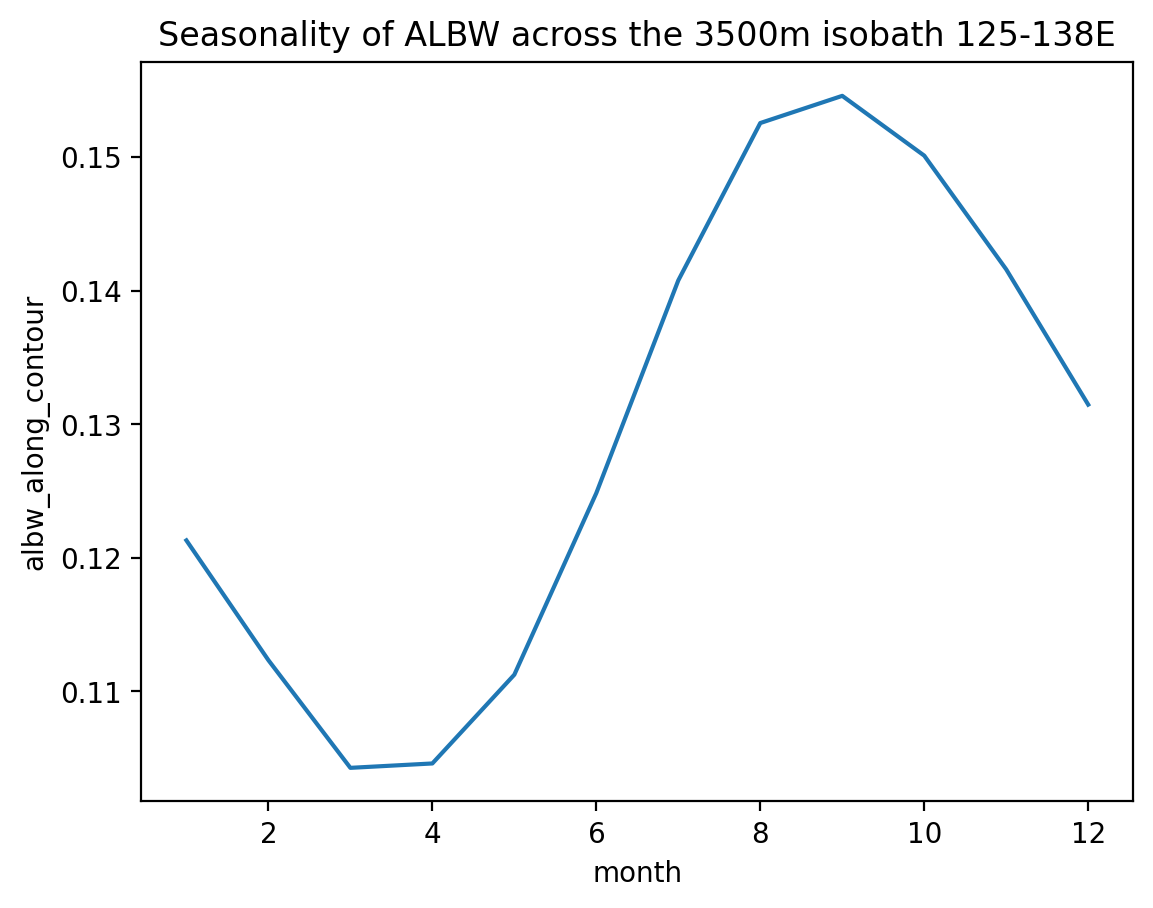

In [140]:
albw_along_contour.mean('contour_index').groupby('time.month').mean('time').plot(label='seasonality')
plt.title('Seasonality of ALBW across the 3500m isobath 125-138E')

### Same for RSBW

In [141]:
rsbw_along_contour = xr.DataArray(np.zeros((len(rsbw.time),len(contour_index_array))),
                              coords = [rsbw.time, contour_index_array],
                              dims = ['time','contour_index'],
                              name = 'rsbw_along_contour')
rsbw_along_contour

<xarray.DataArray 'rsbw_along_contour' (time: 732, contour_index: 225)> Size: 1MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time           (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-...
  * contour_index  (contour_index) int64 2kB 1 2 3 4 5 6 ... 221 222 223 224 225

In [142]:
for time_step in range(len(rsbw_along_contour.time)):
    compute_var_along_contour(rsbw_xgrid, rsbw_ygrid, rsbw_along_contour)
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 1.0, 'Rolling mean of RSBW tracer across the 3500 m isobath (125-138E)')

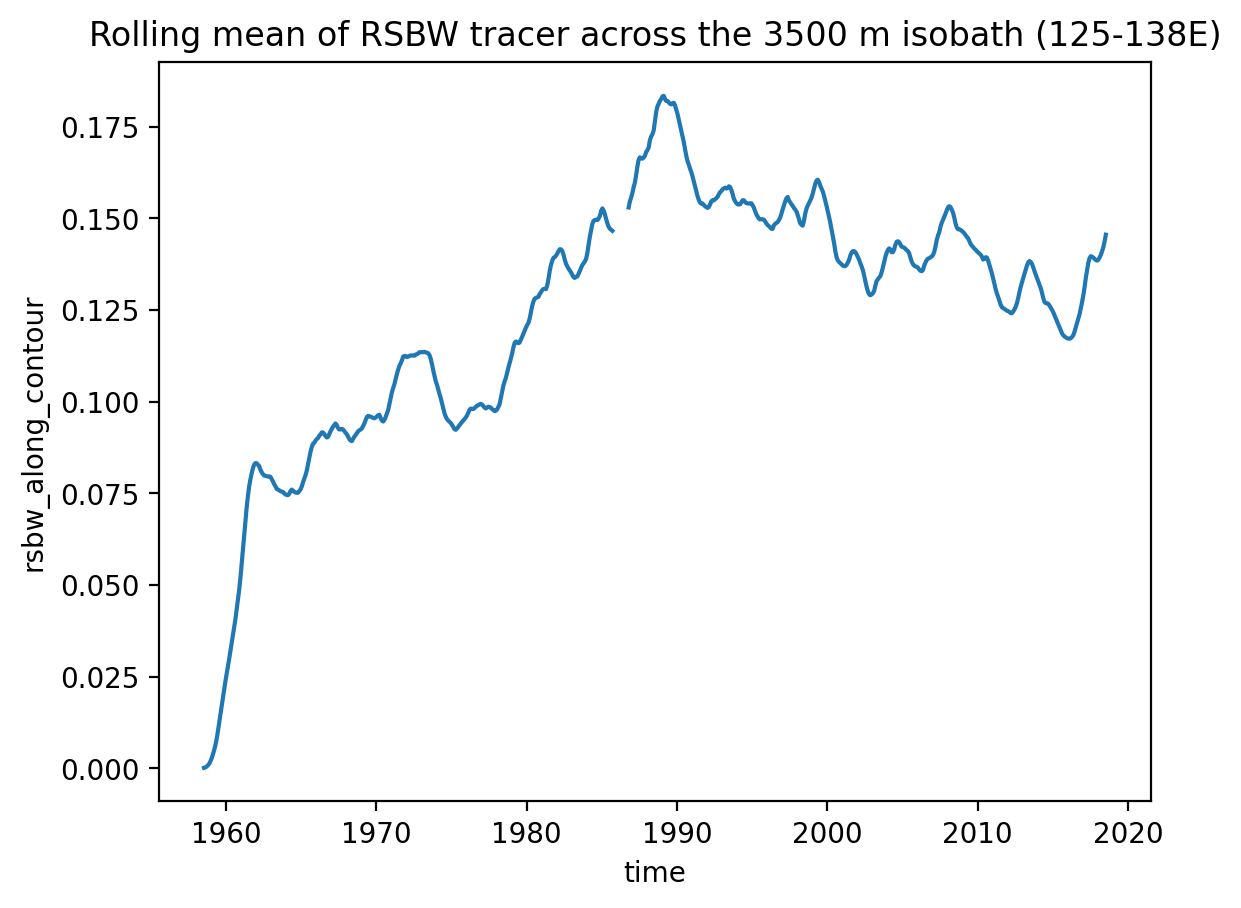

In [143]:
rsbw_along_contour.mean('contour_index').rolling(time=12,center=True).mean('time').plot()
plt.title('Rolling mean of RSBW tracer across the 3500 m isobath (125-138E)')

Text(0.5, 1.0, 'Seasonality of RSBW across the 3500m isobath 125-138E')

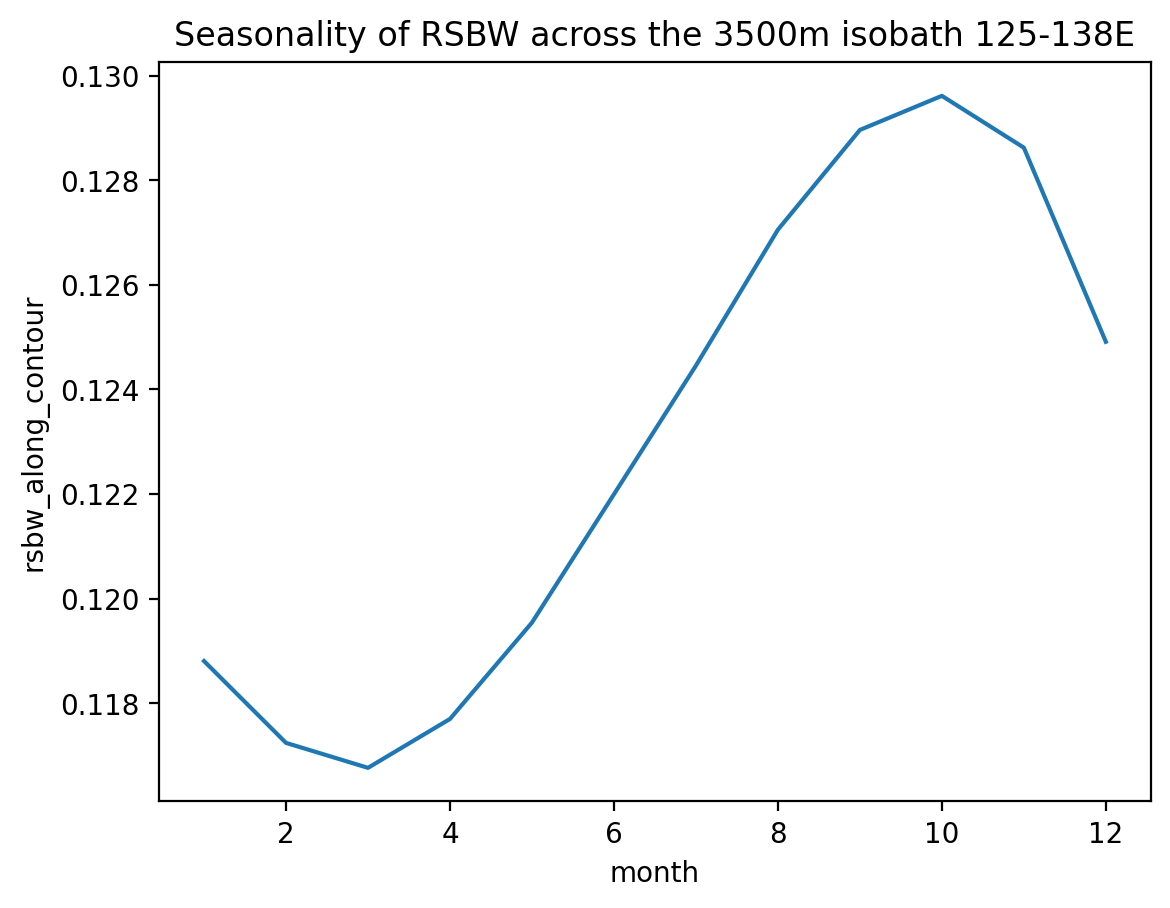

In [144]:
rsbw_along_contour.mean('contour_index').groupby('time.month').mean('time').plot(label='seasonality')
plt.title('Seasonality of RSBW across the 3500m isobath 125-138E')

In [145]:
fpath = '/g/data/x77/ps7863/data/Isobath_contours_circumpolar_upd/Antarctic_slope_contour_1000m.npz'

data = np.load(fpath)
lon_along_contour = data['lon_along_contour']
lat_along_contour = data['lat_along_contour']
xt_ocean = data['xt_ocean']
yt_ocean = data['yt_ocean']
xu_ocean = data['xu_ocean']
yu_ocean = data['yu_ocean']
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']


In [146]:
mask_x_transport = xr.DataArray(
    mask_x_transport,
    coords=[('y_ocean', yt_ocean.data), ('x_ocean', xu_ocean.data)])
mask_y_transport = xr.DataArray(
    mask_y_transport,
    coords=[('y_ocean', yu_ocean.data), ('x_ocean', xt_ocean.data)])
mask_x_transport_numbered = xr.DataArray(
    mask_x_transport_numbered,
    coords=[('y_ocean', yt_ocean.data), ('x_ocean', xu_ocean.data)])
mask_y_transport_numbered = xr.DataArray(
    mask_y_transport_numbered,
    coords=[('y_ocean', yu_ocean.data), ('x_ocean', xt_ocean.data)])

In [148]:
(190-80)/0.1

1100.0

In [149]:
lon_slice_3 = slice(900, 1100)

In [150]:

mask_x_transport = mask_x_transport.isel(x_ocean=lon_slice_3)
mask_y_transport = mask_y_transport.isel(x_ocean=lon_slice_3)
mask_x_transport_numbered = mask_x_transport_numbered.isel(x_ocean=lon_slice_3)
mask_y_transport_numbered = mask_y_transport_numbered.isel(x_ocean=lon_slice_3)

In [151]:
mask_y_transport

<xarray.DataArray (y_ocean: 510, x_ocean: 200)> Size: 408kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * y_ocean  (y_ocean) float64 4kB -81.09 -81.05 -81.0 ... -59.11 -59.06 -59.01
  * x_ocean  (x_ocean) float64 2kB -189.9 -189.8 -189.7 ... -170.2 -170.1 -170.0

In [152]:
num_points = int(np.maximum(np.max(mask_y_transport_numbered),
                 np.max(mask_x_transport_numbered)))
num_points

1852

In [153]:
mask_x_numbered_1d = mask_x_transport_numbered.stack(
    contour_index=['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(
    mask_x_numbered_1d > 0, drop=True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(
    contour_index=['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(
    mask_y_numbered_1d > 0, drop=True)
contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d),
                             dim='contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
contour_index_array = np.arange(1, len(contour_ordering)+1)
# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array